In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install evalseg
!pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#DONT RUN AGAIN
#! unzip /content/drive/MyDrive/Copy_CT.zip -d /content/images

Data was transfered to drive before continuing.

Top 2 lines should not be run again

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
img = nib.load('/content/drive/MyDrive/images/021.nii').get_data()
print(type(img))

FileNotFoundError: ignored

In [ ]:
img.shape

NameError: ignored

In [ ]:
plt.imshow(img[:,:,7])

NameError: ignored

In [ ]:
import pickle
import numpy as np
import os

(512, 512, 93)


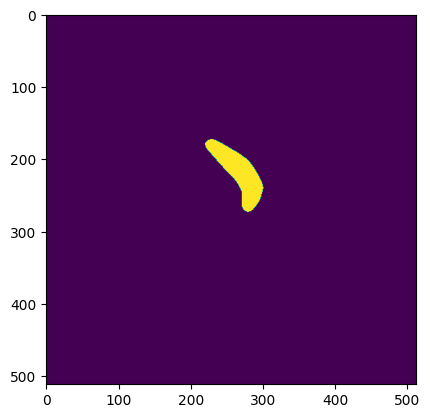

In [ ]:
path='/content/drive/MyDrive/GroundTruth/'
with open(path+'021.pkl',"rb") as file_handle:
    retrieved_data = pickle.load(file_handle)
print(retrieved_data.shape)
plt.imshow(retrieved_data[:,:,45])

In [ ]:
import PIL
from PIL import Image

In [ ]:
number=[]
gt=[]
for filename in os.listdir('/content/drive/MyDrive/GroundTruth'):
  if filename[-3:] == 'pkl':
    number.append(filename[:3])
    f=open(path+filename,'rb')
    #print(f)
    #gt.append(pickle.load(f)[:,:,:])
    patient = (pickle.load(f)[:,:,:])
    if len(number)<55:
      for slice_num in np.arange(patient.shape[2]):
        #Image.fromarray(patient[:,:,slice_num]).save("/content/drive/MyDrive/GroundTruth/train/"+filename[:3][0:3]+'_'+str(slice_num+1).zfill(3)+'.jpg')
        plt.imsave("/content/drive/MyDrive/GroundTruth/train/"+filename[:3][0:3]+'_'+str(slice_num+1).zfill(3)+'.jpg',patient[:,:,slice_num])
    else:
      for slice_num in np.arange(patient.shape[2]):
        #Image.fromarray(patient[:,:,slice_num]).save("/content/drive/MyDrive/GroundTruth/test/"+filename[:3][0:3]+'_'+str(slice_num+1).zfill(3)+'.jpg')
        plt.imsave("/content/drive/MyDrive/GroundTruth/test/"+filename[:3][0:3]+'_'+str(slice_num+1).zfill(3)+'.jpg',patient[:,:,slice_num])

In [ ]:
!rm -r /content/drive/MyDrive/GroundTruth/test
!rm -r /content/drive/MyDrive/GroundTruth/train
!mkdir /content/drive/MyDrive/GroundTruth/test
!mkdir /content/drive/MyDrive/GroundTruth/train

In [ ]:
gt[0].shape[2]

In [ ]:
nibs=[]
for filename in os.listdir('/content/drive/MyDrive/images'):
      if filename[:3] in number:
        nibs.append(filename)
        #nibs.append('/content/drive/MyDrive/images/'+filename)
nibs.sort()

train = nibs[:55]
test = nibs[55:]

for n in train:
  #print(n)
  patient = nib.load('/content/drive/MyDrive/images/'+n).get_fdata()
  for slice_num in np.arange(patient.shape[2]):
    path = "/content/drive/MyDrive/images/train/"+n[0:3]+'_'+str(slice_num+1).zfill(3)+'.jpg'
    plt.imsave(path, patient[:,:,slice_num])

for n in test:
  #print(n)
  patient = nib.load('/content/drive/MyDrive/images/'+n).get_fdata()
  for slice_num in np.arange(patient.shape[2]):
    path = "/content/drive/MyDrive/images/test/"+n[0:3]+'_'+str(slice_num+1).zfill(3)+'.jpg'
    plt.imsave(path, patient[:,:,slice_num])

In [ ]:
!rm -r /content/drive/MyDrive/images/test
!rm -r /content/drive/MyDrive/images/train
!mkdir /content/drive/MyDrive/images/test
!mkdir /content/drive/MyDrive/images/train

ResNet50

In [ ]:
#from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
import cv2

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, split, transforms=transforms.ToTensor()):
        self.root = root
        self.transforms = transforms
        self.split = split
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root,"scans",split))))
        self.imgs = self.imgs[:(len(self.imgs)//32)*32]
        print(len(self.imgs))
        self.masks = list(sorted(os.listdir(os.path.join(root,"gt",split))))
        self.masks = self.masks[:(len(self.masks)//32)*32]
        print(len(self.masks))

    def __getitem__(self, idx):
        # load images ad masks
        if(idx >= len(self.imgs)):
          print('ERROR',idx)
        img_path = os.path.join(self.root, "scans", self.split, self.imgs[idx])
        mask_path = os.path.join(self.root, "gt", self.split, self.masks[idx])
        img = Image.open(img_path)#.convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = cv2.imread(mask_path,2)
        ret,mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)

        #mask = np.array(mask)
        #print(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        #obj_ids = np.asarray(obj_ids[1:])#CONVERTS SINGLE INT TO NP ARRAY WHEN ONLY 2 CLASSES

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        # if len(boxes) == 0:
        #   boxes.append([0,0,0,0])
        boxes = torch.as_tensor(boxes, dtype=torch.float32) #add squeeze since only 1 class?
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        #image_id = torch.tensor([idx])
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        #iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        #target["image_id"] = image_id
        #target["area"] = area
        #target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# # Data augmentation and normalization for training
# # Just normalization for validation
data_dir = '/content/drive/MyDrive/images'

trainDS = ImageDataset(root=data_dir,split='train')
testDS = ImageDataset(root=data_dir,split='test')
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

4864
4864
3552
3552
[INFO] found 4864 examples in the training set...
[INFO] found 3552 examples in the test set...


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
import utils

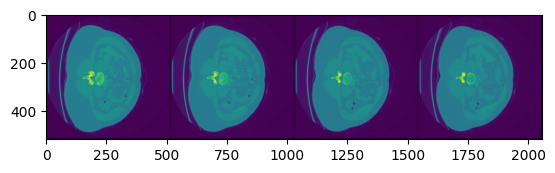

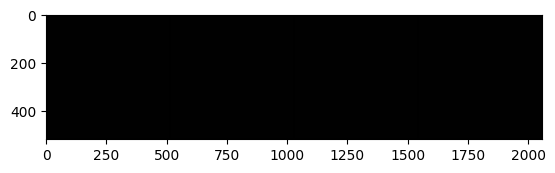

In [ ]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    trainDS, batch_size=4, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn
    )

thing = iter(data_loader)
images,targets = next(thing)

#print('TESTTTT',len(images))

out = torchvision.utils.make_grid(list(images))
out = out.numpy().transpose((1,2,0))
plt.imshow(out)
plt.show()

masks = [t['masks'] for t in targets]
shapes = [t['masks'].shape for t in targets]
#ids = [t['image_id'] for t in targets]
out = torchvision.utils.make_grid(masks)
out = out.numpy().transpose((1,2,0))
plt.imshow(out)
plt.show()
#print(ids,'\n')

#images,targets = next(thing)
#ids = [t['image_id'] for t in targets]
#print(ids)

# For Training

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes, pretrained):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [ ]:
# create the training and test data loaders
trainLoader = torch.utils.data.DataLoader(
    trainDS, batch_size=16, shuffle=False, num_workers=6,
    collate_fn=utils.collate_fn
    )
testLoader = torch.utils.data.DataLoader(
    testDS, batch_size=16, shuffle=False, num_workers=6,
    collate_fn=utils.collate_fn
    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
#model = build_model(num_classes)
# move model to the right device
model = get_instance_segmentation_model(num_classes = 2, pretrained = True)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You 

In [ ]:
from engine import train_one_epoch, evaluate

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 batches
    train_one_epoch(model, optimizer, trainLoader, device, epoch, print_freq=12)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, testLoader, device=device)

Epoch: [0]  [  0/304]  eta: 8:34:55  lr: 0.000021  loss: 11.3546 (11.3546)  loss_classifier: 0.6457 (0.6457)  loss_box_reg: 0.1084 (0.1084)  loss_mask: 10.5848 (10.5848)  loss_objectness: 0.0038 (0.0038)  loss_rpn_box_reg: 0.0120 (0.0120)  time: 101.6314  data: 49.4388  max mem: 13563
Epoch: [0]  [ 12/304]  eta: 0:58:36  lr: 0.000219  loss: 1.7198 (3.5898)  loss_classifier: 0.4631 (0.4329)  loss_box_reg: 0.0979 (0.1099)  loss_mask: 1.2253 (2.9952)  loss_objectness: 0.0069 (0.0284)  loss_rpn_box_reg: 0.0250 (0.0234)  time: 12.0414  data: 3.8453  max mem: 13563
Epoch: [0]  [ 24/304]  eta: 0:41:23  lr: 0.000417  loss: 0.3183 (2.2867)  loss_classifier: 0.1282 (0.2718)  loss_box_reg: 0.0807 (0.1061)  loss_mask: 0.0439 (1.8400)  loss_objectness: 0.0122 (0.0454)  loss_rpn_box_reg: 0.0249 (0.0235)  time: 5.0165  data: 0.0421  max mem: 13563
Epoch: [0]  [ 36/304]  eta: 0:38:41  lr: 0.000615  loss: 0.2351 (1.6690)  loss_classifier: 0.0736 (0.2113)  loss_box_reg: 0.0887 (0.1030)  loss_mask: 0.043

In [ ]:
torch.save(model,'/content/drive/MyDrive/not_pretrained.pth')

In [ ]:
ims,tar = next(iter(testLoader))
images = list(img.to(device) for img in ims)
model = get_instance_segmentation_model(num_classes = 2, pretrained = True)
model.to(device)
model.eval()
outputs = model(images)

outputs = [{k: v.cpu().detach().numpy() for k, v in t.items()} for t in outputs]

KeyboardInterrupt: ignored

In [ ]:
pretrained=torch.load('/content/drive/MyDrive/resnet_pretrained.pth')

RuntimeError: ignored